In [1153]:
# ============================================================================
# JPA（约瑟夫森参量放大器）自动工作点寻找与优化系统
# 
# 本notebook用于：
# 1. 自动寻找JPA的最优直流偏置点
# 2. 优化微波泵浦功率和频率
# 3. 测量放大器的增益、带宽和动态范围
# 4. 生成标准化测试报告
# ============================================================================

# 导入必要的库并设置matplotlib参数用于科学图表绘制
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

# 设置科学图表的matplotlib参数
plt.rcParams['xtick.direction'] = 'in'        # 刻度向内
plt.rcParams['ytick.direction'] = 'in'        # 刻度向内
plt.rcParams['xtick.top'] = True               # 顶部显示刻度
plt.rcParams['ytick.right'] = True             # 右侧显示刻度
plt.rcParams['xtick.minor.visible'] = True     # 显示小刻度
plt.rcParams['ytick.minor.visible'] = True     # 显示小刻度
plt.rcParams['image.origin'] = 'lower'         # 图像原点在左下角
plt.rcParams['figure.figsize'] = [8, 2.5]     # 默认图表尺寸
plt.rcParams['font.size'] = 8                  # 字体大小
plt.rcParams['lines.linewidth'] = 1           # 线宽
plt.rcParams['lines.markersize'] = 2          # 标记大小
plt.rcParams['lines.marker'] = '.'            # 默认标记
plt.rcParams['pdf.fonttype'] = 42             # PDF字体类型（用于矢量图）
plt.rcParams['ps.fonttype'] = 42              # PS字体类型
plt.rcParams['xtick.labelsize'] = 8           # x轴标签大小
plt.rcParams['ytick.labelsize'] = 8           # y轴标签大小
plt.rcParams['savefig.dpi'] = 300             # 保存图像分辨率
plt.rcParams['savefig.format'] = 'pdf'        # 默认保存格式
plt.rcParams['axes.titlesize'] = 'medium'     # 标题字体大小

# 连接到Quark服务器

Quark是一个量子实验控制系统，用于管理和控制各种实验设备。本节建立与服务器的连接以便后续控制实验设备。

In [1154]:
# 导入Quark登录模块并建立连接
from quark.app import login

# 登录到BAQIS（北京量子信息科学研究院）的Quark服务器
# 服务器将加载之前保存的设备配置和检查点
s = login('baqis')

2025-06-21 15:53:01.385 | INFO     | quark.app:login:128 - LOGINED[baqis], Checkpoint[2025-05-30 10:43:32 Fri] loaded from: /Users/xgkj2/Desktop/home/cfg/JPA_TEST.ckpt


In [1155]:
# 启动Quark服务器
# 这将初始化所有连接的实验设备，使其处于可控制状态
s.start()

'QuarkServer started!'

# 工具函数定义

本节定义了实验中使用的各种工具函数，包括：
- 数据处理和可视化函数
- 设备控制的包装函数
- 测量数据的采集和分析函数

In [1156]:
# ============================================================================
# 核心工具函数定义
# ============================================================================

def extent(A, B):
    """
    计算二维数据的边界范围，用于matplotlib的imshow等函数
    
    参数:
        A, B: 一维数组，表示x和y轴的数据范围
    
    返回:
        tuple: (xmin, xmax, ymin, ymax) 用于设置图像边界
    """
    da, db = (A[1]-A[0])/2, (B[1]-B[0])/2
    return A[0]-da, A[-1]+da, B[0]-db, B[-1]+db

def server_read(channel):
    """
    从Quark服务器读取指定通道的数据
    
    参数:
        channel: 字符串，设备通道名称（格式：设备名.通道名.参数名）
    
    返回:
        读取到的数值
    """
    chs = channel.split('.')
    return s.read(channel)[chs[0]]['.'.join(chs[1:])]

import time
def slowly_change(ed, st=None, per=0.01, channel='DC.CH1.Offset', write=False, slow=True, time_out=0.05, **kw):
    """
    缓慢改变设备参数，避免突变对设备造成损害
    
    参数:
        ed: 目标值
        st: 起始值（如果为None则读取当前值）
        per: 每步变化量
        channel: 设备通道
        write: 是否实际写入设备（False时仅打印）
        slow: 是否使用缓慢变化模式
        time_out: 每步之间的等待时间
    """
    def _set_server(value, channel=channel, write=write, time_out=time_out):
        if write:
            s.write(channel, value)
        else:
            print(f'set {channel} to {value}')
        time.sleep(time_out)
    
    if slow:
        if st is None:
            st = server_read(channel)
        if ed-st!=0:
            # 按照指定步长逐步变化
            for mid in np.arange(st+per*np.sign(ed-st), ed, per*np.sign(ed-st)):
                _set_server(mid)
    _set_server(ed)
    
def get_norm(x):
    """
    将数据归一化到[0.05, 0.95]范围，用于颜色映射
    
    参数:
        x: 输入数组
    
    返回:
        归一化后的数组
    """
    return (x-x.min())/(x.max()-x.min())*0.9+0.05

def get_repeat_s(channel, repeat, _time_out=0.01, bar=True):
    """
    重复测量S参数数据，用于统计分析
    
    参数:
        channel: 测量通道
        repeat: 重复次数
        _time_out: 每次测量间隔
        bar: 是否显示进度条
    
    返回:
        numpy数组，形状为(repeat, 频率点数)
    """
    s1s = []
    import time, tqdm
    iters = tqdm.tqdm(range(repeat)) if bar else range(repeat)
    for _ in iters:
        s1 = server_read(channel+'.S')
        time.sleep(_time_out)
        s1s.append(s1)
    return np.array(s1s)

def from_s_get_logabs_db(s):
    """
    将S参数转换为dB单位的幅度
    
    参数:
        s: 复数S参数
    
    返回:
        以dB为单位的幅度
    """
    return 20*np.log10(np.abs(s))

# 导入数据选取工具和进度条
from qulab.visualization.widgets import DataPicker
import tqdm

# 设备初始化设置

本节对JPA测试所需的各种设备进行初始化配置，包括：
- **网络分析仪(NA)**: 用于测量S参数，评估放大器的传输特性
- **直流源(DC)**: 提供JPA的直流偏置，控制工作点
- **微波源(MW)**: 提供泵浦信号，激活参量放大

## 网络分析仪(NA)设置

网络分析仪用于测量JPA的S21参数（传输系数），通过比较泵浦开启前后的信号强度来评估放大器性能。

In [320]:
# 设置网分中频带宽为1000Hz
# 较小的带宽可以提高测量精度，但会增加测量时间
s.write('na_103_220.CH1.Bandwidth', 1000)

{'na_103_220': {'CH1.Bandwidth': 1000,
  'trace': {'CH1.Bandwidth': 0.0, 'total': 0.0, 'actual': 0.0}}}

In [321]:
# 设置网分中心频率为7GHz
# 这是JPA的预期工作频率范围中心
s.write('na_103_220.CH1.FrequencyCenter', 7e9)

{'na_103_220': {'CH1.FrequencyCenter': 7000000000.0,
  'trace': {'CH1.FrequencyCenter': 0.0, 'total': 0.0, 'actual': 0.0}}}

In [322]:
# 设置网分频率展宽为2GHz（6-8GHz）
# 覆盖JPA的工作频率范围
s.write('na_103_220.CH1.FrequencySpan', 2e9)

{'na_103_220': {'CH1.FrequencySpan': 2000000000.0,
  'trace': {'CH1.FrequencySpan': 0.0, 'total': 0.0, 'actual': 0.0}}}

In [323]:
# 设置网分扫描点数
s.write('na_103_220.CH1.NumberOfPoints', 501)

{'na_103_220': {'CH1.NumberOfPoints': 501,
  'trace': {'CH1.NumberOfPoints': 0.0, 'total': 0.0, 'actual': 0.0}}}

In [324]:
s.read('na_103_220.CH1.Power')

{'na_103_220': {'CH1.Power': -20.0,
  'trace': {'CH1.Power': 0.001, 'total': 0.001, 'actual': 0.001}}}

## DC

In [325]:
# 设置直流源偏置（Rigol，单位伏特）
s.write('Rigol_199_222.CH1.Offset', 0.1)

{'Rigol_199_222': {'CH1.Offset': 0.1,
  'trace': {'CH1.Offset': 0.002, 'total': 0.002, 'actual': 0.002}}}

In [326]:
s.read('Rigol_199_222.CH1.Offset')['Rigol_199_222']['CH1.Offset']

0.1

In [327]:
# 设置直流源输出使能('ON'/'OFF')
s.write('Rigol_199_222.CH1.Output', 'ON')

{'Rigol_199_222': {'CH1.Output': 'ON',
  'trace': {'CH1.Output': 0.002, 'total': 0.002, 'actual': 0.002}}}

## MW

In [328]:
# 设置微波源输出功率（单位dBm）
s.write('mw_126_22.CH1.Power', 0)

{'mw_126_22': {'CH1.Power': 0,
  'trace': {'CH1.Power': 0.002, 'total': 0.002, 'actual': 0.002}}}

In [329]:
# 设置微波源输出使能（'ON'/'OFF'）
s.write('mw_126_22.CH1.Output', 'ON')

{'mw_126_22': {'CH1.Output': 'ON',
  'trace': {'CH1.Output': 0.001, 'total': 0.001, 'actual': 0.001}}}

In [330]:
# 设置微波源输出频率（单位，Hz）
s.write('mw_126_22.CH1.Frequency', 14e9)

{'mw_126_22': {'CH1.Frequency': 14000000000.0,
  'trace': {'CH1.Frequency': 0.001, 'total': 0.001, 'actual': 0.001}}}

In [331]:
s.read('mw_126_22.CH1.Frequency')['mw_126_22']['CH1.Frequency']

14000000000.0

In [735]:
s.write('na_103_220.CH1.Output', 'OFF')
s.write('Rigol_199_222.CH1.Output', 'OFF')
s.write('mw_126_22.CH1.Output', 'OFF')
s.write('na_103_220.CH1.Power', -50)

{'na_103_220': {'CH1.Power': -50,
  'trace': {'CH1.Power': 0.0, 'total': 0.0, 'actual': 0.0}}}

# JPA测试配置

本节定义了JPA测试的完整配置，包括：
- **设备信息**: JPA型号、测试线路参数
- **优化参数**: 微波频率/功率、直流偏置的优化范围
- **测试设置**: 网络分析仪参数、重复测量次数
- **损失函数**: 定义优化目标和评估标准

In [1292]:
# ============================================================================
# JPA测试主配置字典
# 包含了整个测试流程的所有参数和设置
# ============================================================================

JPA_var_config = {
    # JPA器件标识
    'jpa_name': 'JPA20240105_3R_53',
    
    # 测试线路配置
    'wiring': {
        # 各温度平台的衰减器配置（单位：dB）
        'att': {
            'Input line': [40, 0, 0, 20, 0, None],    # 输入线：MXC, CP, Still, PT1, PT2, RT
            'Output line': [None, None, None, 0, 0, None],  # 输出线：各平台衰减值
            'Pump line': [None, 0, 0, 20, 0, None],   # 泵浦线：注意None表示无衰减器
        },
        'input_line_filter': 'LPF(8G)+CR110',  # 输入线滤波器：8GHz低通+冷负载
        
        # 测试设备型号信息
        'device_model': {
            'VNA': 'Ceyear 3674E',          # 网络分析仪
            'DC Source': 'Rigol DG1062Z',   # 直流源（用于偏置）
            'MW Source': 'Keysight N5183B', # 微波源（用于泵浦）
            'DR': 'ZL 400'                  # 稀释制冷机
        },
    },
    
    # 优化参数配置：定义三个关键参数的优化范围和步长
    'opt_params': {
        # 微波泵浦频率优化参数
        'mw_frequency': {
            'channel': 'mw_126_22.CH1.Frequency',  # 设备通道
            'per': 1e6,          # 优化步长：1MHz
            'pattern': 'add',    # 优化模式：增量式
            'init': 13.971e9,    # 初始值：13.971GHz（约为信号频率的2倍）
            'low': -5e6,         # 下限：相对于初始值-5MHz
            'high': 5e6,         # 上限：相对于初始值+5MHz
            'time_out': 0.1,     # 设置后等待时间
            'label': 'MW Frequency (Hz)'
        },
        
        # 微波泵浦功率优化参数
        'mw_power': {
            'channel': 'mw_126_22.CH1.Power',
            'per': 0.5,          # 步长：0.5dBm
            'pattern': 'add',    # 增量式优化
            'init': -2.46,       # 初始功率：-2.46dBm
            'low': -0.5,         # 相对下限：-0.5dBm
            'high': 0.5,         # 相对上限：+0.5dBm
            'time_out': 0.1,
            'off_value': -20,    # 泵浦关闭时的功率：-20dBm
            'label': 'MW Power (dBm)'
        },
        
        # 直流偏置优化参数
        'dc_bias': {
            'channel': 'Rigol_199_222.CH1.Offset',
            'per': 0.01,         # 步长：10mV
            'pattern': 'add',    # 增量式优化
            'init': -0.073,      # 初始偏置：-73mV
            'low': -0.01,        # 相对下限：-10mV
            'high': 0.01,        # 相对上限：+10mV
            'time_out': 0.1,
            'label': 'DC Bias (V)'
        },
    },
    
    # 优化算法配置
    'opt_config': {
        'method': 'TwoPointsDE',    # 优化方法：双点差分进化算法
        'config': {'budget': 20},   # 优化预算：最多20次迭代
    },
    
    # 损失函数测量设置
    'lost_setting': {
        'channel': 'na_103_220.CH1',  # 网络分析仪通道
        'params': {
            'FrequencyCenter': 7e9,    # 中心频率：7GHz
            'FrequencySpan': 2e9,      # 频率范围：2GHz（6-8GHz）
            'NumberOfPoints': 51,       # 频率点数：51点
            'Bandwidth': 5000,         # 中频带宽：5kHz
            'Power': -30,              # 测试信号功率：-30dBm
        },
        'repeat': 40,                  # 重复测量次数（用于统计）
        'label': 'NA Scan Frequency (GHz)',
    },
    
    # 损失函数定义
    'lost_function': {
        'range': [0, 60],              # SNR有效范围：0-60dB
        # 频率权重函数：在6.5-7.5GHz范围内权重为1，其他为0
        'func': lambda x: np.piecewise(x, [(6.5e9<=x)*(x<=7.5e9)], [1, 0]),
    },
    
    'time_out': 0.5,  # 默认等待时间
    
    # 测试报告存储（由测试过程填充）
    'report': {
        'Idle_point_without_pump': np.float64(0.1358808984127361),  # 最优空载偏置点
        'FIG2': 'JPA20240105_3R_53_Scan_SNR_vs_Bias.pdf',         # 偏置扫描图
        'gain': np.float64(7.68191558137425),                      # 测得增益
        'bandwith': 367766823.8319765,                             # 测得带宽
        'range': ([6.95461852e+09, 7.32238534e+09]),              # 工作频率范围
        'FIG3': 'JPA20240105_3R_53_Opt_Gain.pdf'                  # 增益优化图
    }  
}

In [1289]:
JPA_var_config['report']

{'Idle_point_without_pump': np.float64(0.1358808984127361),
 'FIG2': 'JPA20240105_3R_53_Scan_SNR_vs_Bias.pdf',
 'gain': np.float64(7.68191558137425),
 'bandwith': 367766823.8319765,
 'range': array([6.95461852e+09, 7.32238534e+09]),
 'FIG3': 'JPA20240105_3R_53_Opt_Gain.pdf'}

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_34111/540856187.py:14: SyntaxWarning: invalid escape sequence '\s'
  (0.4, 0, 0.01, 0.85, f'CP ($\sim100~$mK)'),
/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_34111/540856187.py:15: SyntaxWarning: invalid escape sequence '\s'
  (0.8,  0, 0.01, 1.05, f'Still ($\sim1~$K)'),


<IPython.core.display.Javascript object>


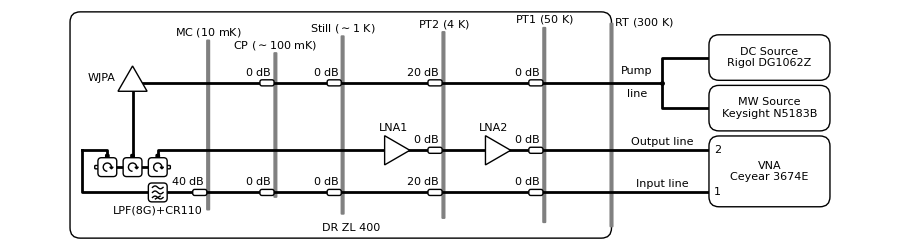

In [974]:
# ============================================================================
# JPA测试电路图绘制函数
# 生成用于报告的标准化电路图，显示测试线路的配置和衰减器设置
# ============================================================================

def draw_JPA_text_circuit():
    """
    绘制JPA测试电路的示意图
    
    该函数根据JPA_var_config中的配置信息，绘制包含以下元素的电路图：
    - 稀释制冷机的各个温度平台（MXC, CP, Still, PT1, PT2, RT）
    - 输入线、输出线、泵浦线的布线
    - 各平台的衰减器配置
    - 滤波器和放大器的位置
    - 测试设备的连接
    
    返回:
        fig, ax: matplotlib图形对象
    """
    import matplotlib.patches as mp

    fig, ax = plt.subplots(figsize=[9, 2.5])

    ax.set_xticks([])
    ax.set_yticks([])
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)

    line_pos = {'Input line':-0.4, 'Output line': -0.15, 'Pump line': 0.25}
    plates = [
        (0,    0, 0.01, 1,    f'MC ($10~$mK)'), 
        (0.4, 0, 0.01, 0.85, f'CP ($\sim100~$mK)'),
        (0.8,  0, 0.01, 1.05, f'Still ($\sim1~$K)'),
        (1.4, 0, 0.01, 1.1,  f'PT2 ($4~$K)'),
        (2,  0, 0.01, 1.15, f'PT1 ($50~$K)'),
        (2.4,    0, 0.01, 1.2,  f'RT ($300~$K)')
    ]
    atts = JPA_var_config['wiring']['att']
    input_line_filter = JPA_var_config['wiring']['input_line_filter']
    models = JPA_var_config['wiring']['device_model']

    for i, item in enumerate(plates):
        x, y, w, h, s = item
        ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={w*0.3}', facecolor='gray', edgecolor='gray'))
        if i<5:
            ax.text(x, y+h/2+w, s, ha='center', va='bottom')

        for k in line_pos:
            yy = line_pos[k]
            if atts[k][i] is not None:
                ww, hh, s = 0.06, 0.012, f'${atts[k][i]}~$dB'
                ax.add_patch(mp.FancyBboxPatch((x-ww*1.2-w*0.8, yy-hh/2), ww, hh, boxstyle=f'Round,pad={ww*0.2}', 
                                               facecolor='w', edgecolor='k', zorder=2))
                ax.text(x-ww*0.2-w*0.8, yy+hh/2+ww*0.4, s, ha='right', va='bottom')

    ax.text(x+w/2+w, y+h/2+w, s, ha='left', va='center')
    
    for k in [
        [[-0.75, -0.75, 3], [line_pos['Output line']]+[line_pos['Input line']]*2],
        [[-0.75, -0.6, -0.6, -0.3, -0.3, 3], [line_pos['Output line']]*2+[line_pos['Output line']-0.1]*2+[line_pos['Output line']]*2],
        [[-0.45, -0.45, 2.7], [line_pos['Output line']-0.1]+[line_pos['Pump line']]*2],
    ]:
        ax.plot(*k, 'k-', lw=2, zorder=1)

    x, y, w, h = -0.3, line_pos['Input line'], 0.07, 0.07
    ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={h*0.3}', facecolor='w', edgecolor='k'))
    theta = np.linspace(0, 2*np.pi, 101)
    for yy in [y+h*0.43, y, y-h*0.43]:
        ax.plot(theta/2/np.pi*w*0.9-w*0.45+x, np.sin(theta)*h*0.12+yy, 'k-')
    ax.plot([x-w*0.2, x+w*0.2], [yy-h*0.12, yy+h*0.12], 'k-')
    ax.text(x, y-h*1.1, input_line_filter, ha='center', va='top')

    for xx in [-0.3, -0.3-0.15, -0.3-0.15*2]:
        x, y, w, h = xx, line_pos['Output line']-0.1, 0.07, 0.07
        ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={h*0.3}', facecolor='w', edgecolor='k'))
        ax.add_patch(mp.Arc((x, y), w*0.7, h*0.7, theta1=0, theta2=270))
        ax.add_patch(mp.Polygon([[x+w*0.35-0.01, y], [x+w*0.35+0.01, y], [x+w*0.35, y-0.01]], closed=True, facecolor='k', edgecolor='k'))

        s = 0.005
        ax.add_patch(mp.FancyBboxPatch((x-s, y+h/2+s*3), s*2, s*4, boxstyle=f'Round,pad={s}', facecolor='k', edgecolor='k', zorder=-1))

    ax.add_patch(mp.FancyBboxPatch((xx-w/2-s*7, y-s), s*4, s*2, boxstyle=f'Round,pad={s}', facecolor='w', edgecolor='k', zorder=-1))
    ax.add_patch(mp.FancyBboxPatch((xx+w/2+s*3+0.15*2, y-s), s*4, s*2, boxstyle=f'Round,pad={s}', facecolor='w', edgecolor='k', zorder=-1))

    x, y, w, h, s = 3.34, (line_pos['Input line']+line_pos['Output line'])/2, 0.6, 0.3, 'VNA'+'\n'+models['VNA']
    ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={w*0.1}', facecolor='w', edgecolor='k'))
    ax.text(x, y, s, ha='center', va='center')
    ax.text(x-w/2-w*0.05, line_pos['Input line'], '1', ha='left', va='center')
    ax.text(x-w/2-w*0.05, line_pos['Output line'], '2', ha='left', va='center')

    x, y, w, h, s = 3.34, line_pos['Pump line']+0.15, 0.6, 0.15, 'DC Source'+'\n'+models['DC Source']
    ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={w*0.1}', facecolor='w', edgecolor='k'))
    ax.text(x, y, s, ha='center', va='center')

    x, y, w, h, s = 3.34, line_pos['Pump line']-0.15, 0.6, 0.15, 'MW Source'+'\n'+models['MW Source']
    ax.add_patch(mp.FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle=f'Round,pad={w*0.1}', facecolor='w', edgecolor='k'))
    ax.text(x, y, s, ha='center', va='center')

    ax.plot([3.24, 2.7, 2.7, 3.24], [line_pos['Pump line']+0.15]*2+[line_pos['Pump line']-0.15]*2, 'k-', lw=2, zorder=-1)
    ax.plot([2.7], [line_pos['Pump line']], 'k.', ms=5)

    x, y, r = -0.45, line_pos['Pump line'], 0.1
    theta_list = np.array([90, 210, 330])/360*np.pi*2
    ax.add_patch(mp.Polygon([[x+r*np.cos(theta), y+r*np.sin(theta)] for theta in theta_list], closed=True, facecolor='w', edgecolor='k'))
    ax.text(x-r, y, 'WJPA', ha='right', va='bottom')
   # ax.text(x, y+r, JPA_var_config['jpa_name'], ha='center', va='bottom')

    x, y, r = 1.4-0.3, line_pos['Output line'], 0.1
    theta_list = np.array([0, 120, 240])/360*np.pi*2
    ax.add_patch(mp.Polygon([[x+r*np.cos(theta), y+r*np.sin(theta)] for theta in theta_list], closed=True, facecolor='w', edgecolor='k'))
    ax.text(x, y+r, 'LNA1', ha='center', va='bottom')

    x, y, r = 2-0.3, line_pos['Output line'], 0.1
    theta_list = np.array([0, 120, 240])/360*np.pi*2
    ax.add_patch(mp.Polygon([[x+r*np.cos(theta), y+r*np.sin(theta)] for theta in theta_list], closed=True, facecolor='w', edgecolor='k'))
    ax.text(x, y+r, 'LNA2', ha='center', va='bottom')
    
    x, y, w, h, s = 0.85, 0, 3.1, 1.22, 'DR '+models['DR']
    ax.add_patch(mp.FancyBboxPatch((x-w/2-h*0.05, y-h/2), w, h, boxstyle=f'Round,pad={h*0.05}', facecolor='w', edgecolor='k', zorder=-2))
    ax.text(x, y-h/2-h*0.025, s, ha='center', va='bottom')
    
    ax.text(2.55, line_pos['Pump line'], 'Pump\n\nline', ha='center', va='center')
    
    ax.text(2.7, line_pos['Input line']+0.02, 'Input line', ha='center', va='bottom')
    ax.text(2.7, line_pos['Output line']+0.02, 'Output line', ha='center', va='bottom')
    
    ax.axis('equal')

    fig.tight_layout(pad=0.05)
    fig.show()
    
    return fig, ax

fig, ax = draw_JPA_text_circuit()

In [975]:
fig.savefig('JPA_test_circuit')

# 网络分析仪测试

本节开始JPA的性能测试。测试流程包括：
1. **偏置扫描**: 测量不同直流偏置下的响应，寻找最优空载工作点
2. **工作点优化**: 同时优化微波频率、功率和直流偏置
3. **性能评估**: 测量增益、带宽和动态范围

In [1166]:
# 生成网分采集频率信息
freqs = np.linspace(
    JPA_var_config['lost_setting']['params']['FrequencyCenter']-JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['FrequencyCenter']+JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['NumberOfPoints'])

# 网分采集设置
for k, v in JPA_var_config['lost_setting']['params'].items():
    slowly_change(ed=v, slow=False, channel=JPA_var_config['lost_setting']['channel']+'.'+k, write=True)

In [1167]:
s1 = server_read(JPA_var_config['lost_setting']['channel']+'.S')

<IPython.core.display.Javascript object>


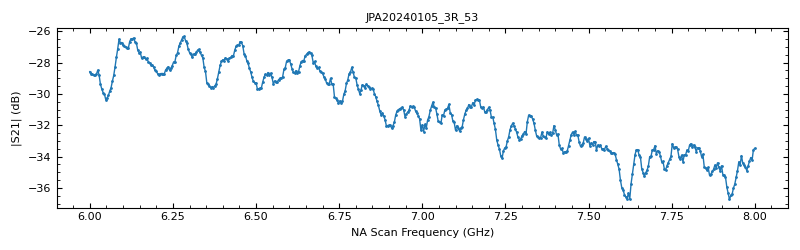

In [1168]:
fig, ax = plt.subplots()

ax.plot(freqs/1e9, from_s_get_logabs_db(s1))
ax.set_xlabel(JPA_var_config['lost_setting']['label'])
ax.set_ylabel('|S21| (dB)')
plt.title(JPA_var_config['jpa_name'])
fig.tight_layout()
fig.show()

# MW Pump Off & Change DC Bias

In [1169]:
# 关闭微波源输出
s.write('mw_126_22.CH1.Output', 'OFF')

{'mw_126_22': {'CH1.Output': 'OFF',
  'trace': {'CH1.Output': 0.001, 'total': 0.001, 'actual': 0.001}}}

In [1170]:
# 打开直流源输出
s.write('Rigol_199_222.CH1.Output', 'ON')

{'Rigol_199_222': {'CH1.Output': 'ON',
  'trace': {'CH1.Output': 0.002, 'total': 0.002, 'actual': 0.002}}}

In [1171]:
# 生成网分采集频率信息
freqs = np.linspace(
    JPA_var_config['lost_setting']['params']['FrequencyCenter']-JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['FrequencyCenter']+JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['NumberOfPoints'])

# 网分采集设置
for k, v in JPA_var_config['lost_setting']['params'].items():
    slowly_change(ed=v, slow=False, channel=JPA_var_config['lost_setting']['channel']+'.'+k, write=True)

## Scan

### single test for a certain bias

In [589]:
# 给入一个初始化偏置，给不给都行
init_bias = 0.1
# s.write('Rigol_199_222.CH1.Offset', init_bias)

In [590]:
s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'])

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]


<IPython.core.display.Javascript object>


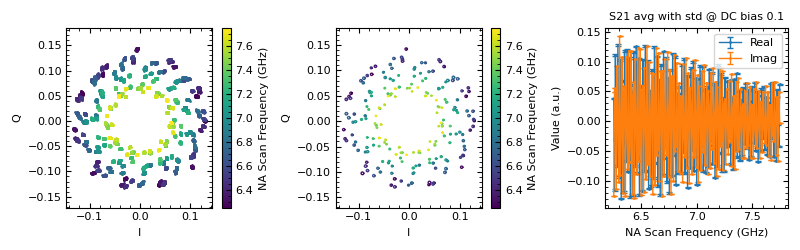

In [150]:
from matplotlib import colormaps
from matplotlib.colors import Normalize
from matplotlib import cm

cmap = colormaps.get('viridis')
norm = Normalize(freqs[0]/1e9, freqs[-1]/1e9)

fig, ax = plt.subplots(1, 3)

for j in range(s1s.shape[1]):
    ax[0].plot(s1s[:, j].real, s1s[:, j].imag, '.', c=cmap(norm(freqs[j]/1e9)))
    
s1_avg, s1_std, s1_abs_std = s1s.mean(axis=0), s1s.std(axis=0), 2*np.abs(s1s).std(axis=0),

# ax[1].scatter(s1_avg.real, s1_avg.imag, c=cmap(norm(freqs)))
phi = np.linspace(0, 2*np.pi, 101)
for j in range(s1s.shape[1]):
    ax[1].plot(s1_avg[j].real+s1_abs_std[j]*np.cos(phi), s1_avg[j].imag+s1_abs_std[j]*np.sin(phi), '-',
               c=cmap(norm(freqs[j]/1e9)))

for i in range(2):
    ax[i].axis('equal')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[i], label=JPA_var_config['lost_setting']['label'])
    ax[i].set_xlabel('I')
    ax[i].set_ylabel('Q')
    
ax[2].errorbar(freqs/1e9, s1_avg.real, s1_std.real, capsize=2, label='Real')
ax[2].errorbar(freqs/1e9, s1_avg.imag, s1_std.imag, capsize=2, label='Imag')
ax[2].set_xlabel(JPA_var_config['lost_setting']['label'])
ax[2].set_ylabel('Value (a.u.)')
ax[2].legend()
ax[2].set_title(f"S21 avg with std @ DC bias {init_bias}", fontsize=8)

fig.tight_layout()
fig.show()

### scan all bias

In [1172]:
bias_list = np.linspace(-0.6, 0.6, 101)

s1ss = []
for bias in tqdm.tqdm(bias_list):
    slowly_change(bias, write=True, **JPA_var_config['opt_params']['dc_bias'])
    s1ss.append(get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                             repeat=JPA_var_config['lost_setting']['repeat'], bar=False))
s1ss = np.array(s1ss).reshape([bias_list.shape[0], -1, freqs.shape[0]])

100%|█████████████████████████████████████████| 101/101 [05:25<00:00,  3.22s/it]


<IPython.core.display.Javascript object>


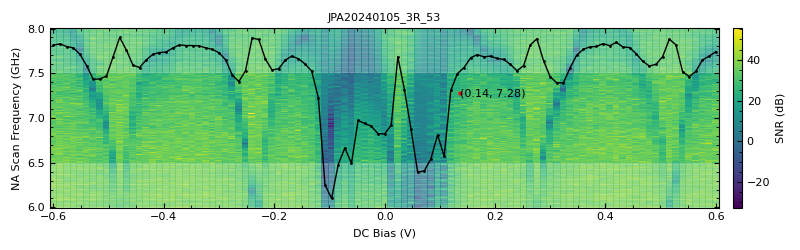

In [1174]:
SNR = from_s_get_logabs_db(np.abs(s1ss.mean(axis=1)/s1ss.std(axis=1)))
SNRR = SNR*(SNR>=JPA_var_config['lost_function']['range'][0])*(SNR<=JPA_var_config['lost_function']['range'][1]) #截取
alpha = 1-(1-JPA_var_config['lost_function']['func'](freqs))*0.7  #显示掩膜

fig, ax = plt.subplots()

cax = ax.pcolor(bias_list, freqs/1e9, SNR.T, alpha=np.kron(alpha, np.ones_like(bias_list)))
fig.colorbar(cax, ax=ax, label='SNR (dB)', aspect=20, pad=0.02, fraction=0.02)

ax.set_xlabel(JPA_var_config['opt_params']['dc_bias']['label'])
ax.set_ylabel(JPA_var_config['lost_setting']['label'])

lost_func = get_norm(np.einsum('ij,j->i', SNRR, JPA_var_config['lost_function']['func'](freqs))) #加权求和
ax.plot(bias_list, lost_func*(freqs[-1]-freqs[0])/1e9+freqs[0]/1e9, c='k')
sec = DataPicker(ax)
plt.title(JPA_var_config['jpa_name'])
fig.tight_layout()
fig.show()

In [1175]:
sbx, sby = sec.get_xy()  #先选一个点，再运行
JPA_var_config['report']['Idle_point_without_pump'] = sbx[0]

In [1176]:
fig.savefig(JPA_var_config['jpa_name']+'_Scan_SNR_vs_Bias')
JPA_var_config['report']['FIG2'] = JPA_var_config['jpa_name']+'_Scan_SNR_vs_Bias.pdf'
JPA_var_config['report']

{'Idle_point_without_pump': np.float64(0.1358808984127361),
 'FIG2': 'JPA20240105_3R_53_Scan_SNR_vs_Bias.pdf'}

## Optimize the idle bias point

In [1179]:
test = NgOpt([VarData(*[v[s] for s in ['pattern', 'init', 'low', 'high']]) 
              for k, v in JPA_var_config['opt_params'].items() if k in ['dc_bias']], JPA_var_config['opt_config'])

In [1180]:
xxs, yys = None, None

for l in range(JPA_var_config['opt_config']['config']['budget']):
    x = test.ask()
    if xxs is None:
        xxs = x.reshape([1, -1])+0
    else:
        xxs = np.concatenate((xxs, x.reshape([1, -1])), axis=0)
#     print(x)
    for i, k in enumerate(['dc_bias']):
        slowly_change(x[i], **JPA_var_config['opt_params'][k], write=True)
    
    s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                       repeat=JPA_var_config['lost_setting']['repeat'])
    
    SNR = 20*np.log10(np.abs(s1s.mean(axis=0)/s1s.std(axis=0)))
    SNRR = SNR*(SNR>=JPA_var_config['lost_function']['range'][0])*(SNR<=JPA_var_config['lost_function']['range'][1])
    y = np.array([SNRR@JPA_var_config['lost_function']['func'](freqs)])
    
    if yys is None:
        yys = y+0
    else:
        yys = np.concatenate((yys, y))
    test.tell(x, -y)

 12%|█████▌                                      | 5/40 [00:03<00:25,  1.37it/s]

[2025-06-21 16:30:18.234][QuarkServer][CRITICAL💀] @RECV: KeyboardInterrupt 


TypeError: string indices must be integers, not 'str'

/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_45383/3950586992.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


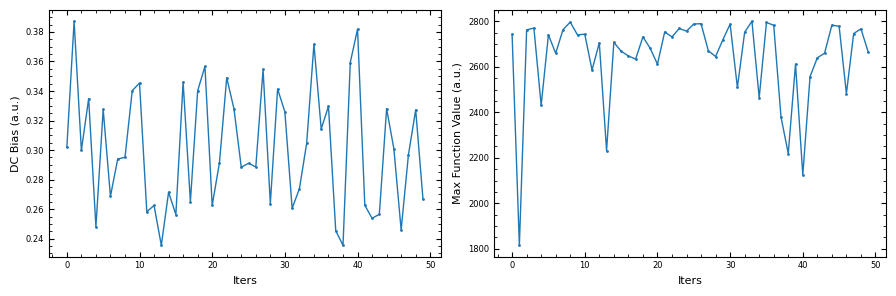

In [331]:
fig, ax = plt.subplots(1, 2)

for i in range(2):
    ax[i].set_xlabel('Iters')

ax[0].plot(xxs)
ax[0].set_xlabel(JPA_var_config['opt_params']['dc_bias']['label'])

ax[1].plot(yys)
ax[1].set_ylabel('Max Function Value (a.u.)')

fig.tight_layout()
fig.show()

In [332]:
init_bias = float(xxs[0])
slowly_change(init_bias, **JPA_var_config['opt_params']['dc_bias'], write=True)

s1_init = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                       repeat=JPA_var_config['lost_setting']['repeat'])

final_bias = float(xxs[np.argmax(yys)])
slowly_change(final_bias, **JPA_var_config['opt_params']['dc_bias'], write=True)

s1_final = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                       repeat=JPA_var_config['lost_setting']['repeat'])

/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_45383/3232259254.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_bias = float(xxs[0])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]
/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_45383/3232259254.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_bias = float(xxs[np.argmax(yys)])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_45383/1456803793.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


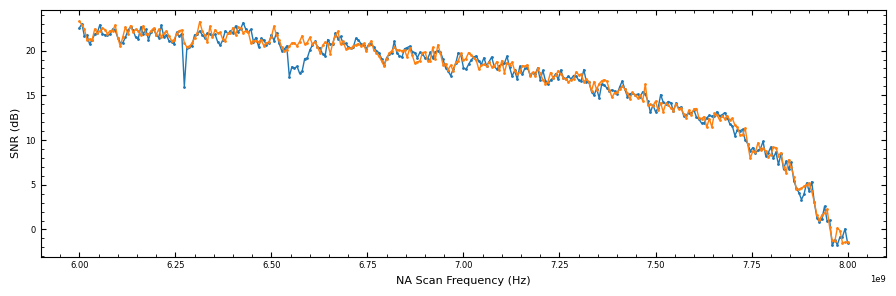

In [334]:
fig, ax = plt.subplots()

ax.plot(freqs, 20*np.log10(np.abs(s1_init.mean(axis=0))/s1_init.std(axis=0)),
        label=f'Init Bias @ {init_bias}')
ax.plot(freqs, 20*np.log10(np.abs(s1_final.mean(axis=0))/s1_final.std(axis=0)),
        label=f'Final Bias @ {final_bias}')

ax.set_ylabel('SNR (dB)')
ax.set_xlabel('NA Scan Frequency (Hz)')
ax.legend()

fig.tight_layout()
fig.show()

# MW Pump On/Off & fixed DC Bias on

In [1293]:
# 打开微波源输出
s.write('mw_126_22.CH1.Output', 'ON')


{'mw_126_22': {'CH1.Output': 'ON',
  'trace': {'CH1.Output': 0.001, 'total': 0.001, 'actual': 0.001}}}

In [1294]:
# 打开直流源输出
s.write('Rigol_199_222.CH1.Output', 'ON')


{'Rigol_199_222': {'CH1.Output': 'ON',
  'trace': {'CH1.Output': 0.002, 'total': 0.002, 'actual': 0.002}}}

In [1295]:
# 生成网分采集频率信息
freqs = np.linspace(
    JPA_var_config['lost_setting']['params']['FrequencyCenter']-JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['FrequencyCenter']+JPA_var_config['lost_setting']['params']['FrequencySpan']/2,
    JPA_var_config['lost_setting']['params']['NumberOfPoints'])

# 网分采集设置
for k, v in JPA_var_config['lost_setting']['params'].items():
    slowly_change(ed=v, slow=False, channel=JPA_var_config['lost_setting']['channel']+'.'+k, write=True)

## Scan 根据相位图 手动优化值

In [1184]:
# 设置初始化泵浦信息
value = 'init'
for i, k in enumerate(JPA_var_config['opt_params']):
    slowly_change(JPA_var_config['opt_params'][k][value], **JPA_var_config['opt_params'][k], write=True)
print(value)

init


In [1185]:
s2s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'])

slowly_change(JPA_var_config['opt_params']['mw_power']['off_value'], 
              write=True, **JPA_var_config['opt_params']['mw_power'])
time.sleep(JPA_var_config['time_out'])

s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'])

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.83it/s]


<IPython.core.display.Javascript object>


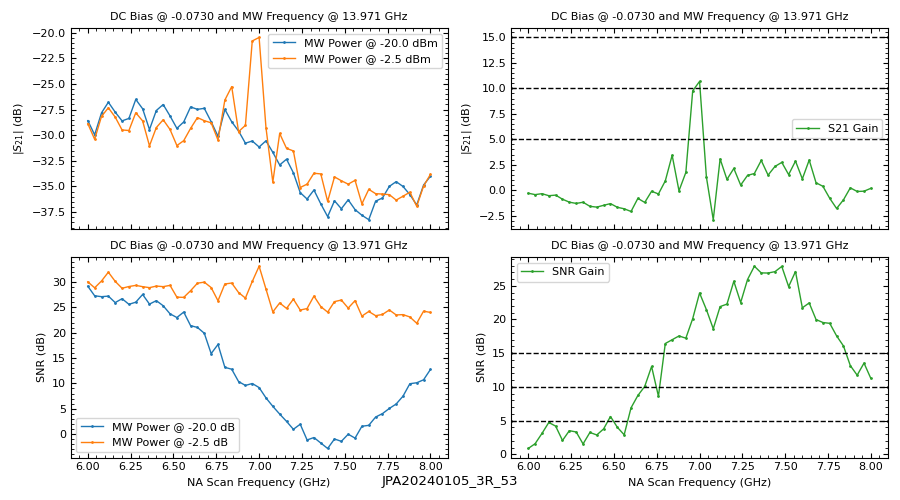

Text(0.5, 0.05, 'JPA20240105_3R_53')

In [1186]:
value = 'init'

fig, ax = plt.subplots(2, 2, figsize=[9, 5], sharex=True)
ax = ax.flatten()

ax[0].plot(freqs/1e9, from_s_get_logabs_db(s1s.mean(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power']['off_value']:.1f} dBm")
ax[0].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power'][value]:.1f} dBm")
ax[1].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/(s1s.mean(axis=0))),
        label=f"S21 Gain", c='C2')

ax[2].plot(freqs/1e9, from_s_get_logabs_db(s1s.mean(axis=0)/s1s.std(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power']['off_value']:.1f} dB")
ax[2].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/s2s.std(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power'][value]:.1f} dB")
ax[3].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/s2s.std(axis=0)/s1s.mean(axis=0)*s1s.std(axis=0)),
        label=f"SNR Gain", c='C2')


for i in range(4):
    ax[i].set_ylabel('$|S_{21}|$ (dB)' if i<2 else 'SNR (dB)')
    if i//2:
        ax[i].set_xlabel(JPA_var_config['lost_setting']['label'])
    ax[i].set_title((f"DC Bias @ {JPA_var_config['opt_params']['dc_bias'][value]:.4f} and "
                    +f"MW Frequency @ {JPA_var_config['opt_params']['mw_frequency'][value]/1e9:.3f} GHz"))
    ax[i].legend()

for v in [5, 10, 15]:
    for j in [1, 3]:
        ax[j].axhline(y=v, c='k', ls='--')  
     
    fig.tight_layout()
    fig.show()
plt.suptitle(JPA_var_config['jpa_name'], y=0.05)   

## Optimize the working point

In [1296]:
test = NgOpt([VarData(*[v[s] for s in ['pattern', 'init', 'low', 'high']]) 
              for k, v in JPA_var_config['opt_params'].items()], JPA_var_config['opt_config'])

In [ ]:
xxs, yys, SNRs = None, None, []
#s2s=pump on, s1s=MW_power@-20dB i.e. pump off
for l in tqdm.tqdm(range(JPA_var_config['opt_config']['config']['budget'])):
    x = test.ask()
    if xxs is None:
        xxs = x.reshape([1, -1])+0
    else:
        xxs = np.concatenate((xxs, x.reshape([1, -1])), axis=0)
#     print(x)
    for i, k in enumerate(JPA_var_config['opt_params']):
        slowly_change(x[i], **JPA_var_config['opt_params'][k], write=True)
    time.sleep(JPA_var_config['time_out'])
    
    s2s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                       repeat=JPA_var_config['lost_setting']['repeat'], bar=False)
    
    slowly_change(JPA_var_config['opt_params']['mw_power']['off_value'], 
                  write=True, **JPA_var_config['opt_params']['mw_power'])
    time.sleep(JPA_var_config['time_out'])

    s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                       repeat=JPA_var_config['lost_setting']['repeat'], bar=False)
    time.sleep(JPA_var_config['time_out'])
    
    SNR_Gain = (from_s_get_logabs_db(s2s.mean(axis=0)/s2s.std(axis=0)/s1s.mean(axis=0)*s1s.std(axis=0))
               +from_s_get_logabs_db(s1s.mean(axis=0)/s1s.std(axis=0))/2)
    
    SNRR = np.clip(SNR_Gain, -45, 20)
    y = np.array([SNRR@JPA_var_config['lost_function']['func'](freqs)])# 优化用的lostfunc
    SNRs.append([s1s.mean(axis=0)/s1s.std(axis=0), s2s.mean(axis=0)/s2s.std(axis=0)])
    
    if yys is None:
        yys = y+0
    else:
        yys = np.concatenate((yys, y))
    test.tell(x, -y)
SNRs = np.array(SNRs)

 90%|██████████████████████████████████████▋    | 18/20 [05:44<00:38, 19.13s/it]

<IPython.core.display.Javascript object>


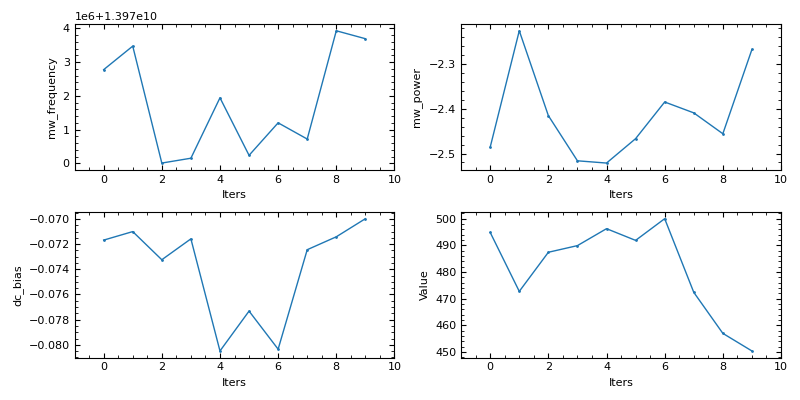

In [1265]:
NN, MM = len(JPA_var_config['opt_params']), 2
fig, ax = plt.subplots((NN+MM-1)//MM, MM, figsize=[8, (NN+MM-1)//MM*2])
ax = ax.flatten()

for i, k in enumerate(JPA_var_config['opt_params']):
    ax[i].set_xlabel('Iters')
    ax[i].plot(xxs[:, i])
    ax[i].set_xlim(-1, l+1)
    ax[i].set_xlabel('Iters')
    ax[i].set_ylabel(k)
    
ax[i+1].plot(yys)
ax[i+1].set_xlim(-1, l+1)
# ax[i+1].set_ylim(200, 2000)
ax[i+1].set_xlabel('Iters')
ax[i+1].set_ylabel('Value')

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


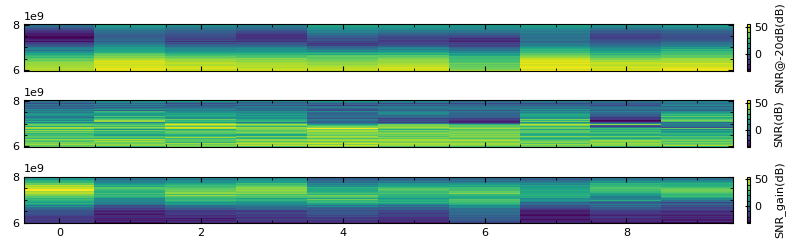

/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_34111/325950880.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 800x250 with 2 Axes> than <Figure size 800x250 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(cax, ax=ax[0], label='SNR@-20dB(dB)', aspect=20, pad=0.02, fraction=0.02)
/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_34111/325950880.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 800x250 with 2 Axes> than <Figure size 800x250 with 5 Axes> which fig.colorbar is called on.
  fig.colorbar(cax, ax=ax[1], label='SNR(dB)', aspect=20, pad=0.02, fraction=0.02)
/var/folders/jf/1br0s8_x2sng4zrvhrvdx14w0000gn/T/ipykernel_34111/325950880.py:10: UserWarning: Adding colorbar to a different Figure <Figure size 800x250 with 2 Axes> than <Figure size 800x250 with 6 Axes> which fig.colorbar is called on.
  fig.colorbar(cax, ax=ax[2], label='SNR_gain(dB)', aspect=20, pad=0.02, fraction=0.02)


In [1267]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].pcolor(np.arange(xxs.shape[0]), freqs, from_s_get_logabs_db(SNRs[:, 0, :].T))
ax[1].pcolor(np.arange(xxs.shape[0]), freqs, from_s_get_logabs_db(SNRs[:, 1, :].T))
ax[2].pcolor(np.arange(xxs.shape[0]), freqs, 
             from_s_get_logabs_db(SNRs[:, 1, :].T)-from_s_get_logabs_db(SNRs[:, 0, :].T))

fig.colorbar(cax, ax=ax[0], label='SNR@-20dB(dB)', aspect=20, pad=0.02, fraction=0.02)
fig.colorbar(cax, ax=ax[1], label='SNR(dB)', aspect=20, pad=0.02, fraction=0.02)
fig.colorbar(cax, ax=ax[2], label='SNR_gain(dB)', aspect=20, pad=0.02, fraction=0.02)


fig.tight_layout()
fig.show()

In [1284]:
# res = test.get_result()
# x = res.x
x = xxs[6]
#ok: xxs[0，3]

# 设置优化后的值到config的final选项中
value = 'final'
for i, k in enumerate(JPA_var_config['opt_params']):
    JPA_var_config['opt_params'][k][value] = x[i]
    slowly_change(JPA_var_config['opt_params'][k][value], **JPA_var_config['opt_params'][k], write=True)
print(x) # MW_freq（ghz),MW_power(dbm),Dc_bais(V)

[ 1.39712022e+10 -2.38477834e+00 -8.03465061e-02]


In [1285]:
# 先重连， 再运行
s2s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'])

slowly_change(JPA_var_config['opt_params']['mw_power']['off_value'], 
              write=True, **JPA_var_config['opt_params']['mw_power'])
time.sleep(JPA_var_config['time_out'])

s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'])

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.93it/s]


<IPython.core.display.Javascript object>


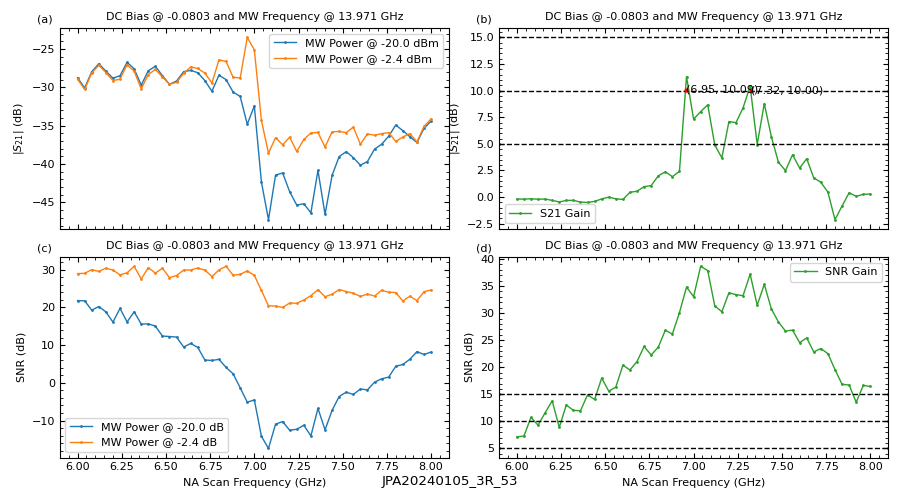

Text(0.5, 0.05, 'JPA20240105_3R_53')

In [1286]:
value = 'final'

fig, ax = plt.subplots(2, 2, figsize=[9, 5], sharex=True)
ax = ax.flatten()

ax[0].plot(freqs/1e9, from_s_get_logabs_db(s1s.mean(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power']['off_value']:.1f} dBm")
ax[0].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power'][value]:.1f} dBm")
ax[1].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/(s1s.mean(axis=0))),
        label=f"S21 Gain", c='C2')

ax[2].plot(freqs/1e9, from_s_get_logabs_db(s1s.mean(axis=0)/s1s.std(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power']['off_value']:.1f} dB")
ax[2].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/s2s.std(axis=0)),
        label=f"MW Power @ {JPA_var_config['opt_params']['mw_power'][value]:.1f} dB")
ax[3].plot(freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/s2s.std(axis=0)/s1s.mean(axis=0)*s1s.std(axis=0)),
        label=f"SNR Gain", c='C2')


for i in range(4):
    ax[i].set_ylabel('$|S_{21}|$ (dB)' if i<2 else 'SNR (dB)')
    if i//2:
        ax[i].set_xlabel(JPA_var_config['lost_setting']['label'])
    ax[i].set_title((f"DC Bias @ {JPA_var_config['opt_params']['dc_bias'][value]:.4f} and "
                    +f"MW Frequency @ {JPA_var_config['opt_params']['mw_frequency'][value]/1e9:.3f} GHz"))
    ax[i].legend()
    ax[i].text(-0.02, 1.02, f"({chr(ord('a')+i)})", ha='right', va='bottom', transform=ax[i].transAxes)

for v in [5, 10, 15]:
    for j in [1, 3]:
        ax[j].axhline(y=v, c='k', ls='--')  
secs = [DataPicker(ax[1]), DataPicker(ax[3])]

fig.tight_layout()
fig.show()
plt.suptitle(JPA_var_config['jpa_name'], y=0.05)   

In [1287]:
s21x, s21y = secs[0].get_xy()
snrx, snry = secs[0].get_xy()

freqq, s21_gain = freqs/1e9, from_s_get_logabs_db(s2s.mean(axis=0)/(s1s.mean(axis=0)))

JPA_var_config['report'].update({
    'gain': np.mean(s21_gain[(s21x[0]<=freqq)*(freqq<=s21x[1])]),
    'bandwith': float(np.diff(s21x)*1e9),
    'range': snrx*1e9,
})

In [1288]:
fig.savefig(JPA_var_config['jpa_name']+'_Opt_Gain')
JPA_var_config['report']['FIG3'] = JPA_var_config['jpa_name']+'_Opt_Gain.pdf'
JPA_var_config['report']

{'Idle_point_without_pump': np.float64(0.1358808984127361),
 'FIG2': 'JPA20240105_3R_53_Scan_SNR_vs_Bias.pdf',
 'gain': np.float64(7.68191558137425),
 'bandwith': 367766823.8319765,
 'range': array([6.95461852e+09, 7.32238534e+09]),
 'FIG3': 'JPA20240105_3R_53_Opt_Gain.pdf'}

# Dynamic range

In [1236]:
value = 'final'
for i, k in enumerate(JPA_var_config['opt_params']):
    JPA_var_config['opt_params'][k][value] = x[i]
    slowly_change(JPA_var_config['opt_params'][k][value], **JPA_var_config['opt_params'][k], write=True)
print(x)

In [911]:
power_list = np.linspace(-40, -10, 11)

s2ss = []
for k, power in enumerate(power_list):
    
    slowly_change(ed=power, slow=False, channel=JPA_var_config['lost_setting']['channel']+'.Power', write=True)
    time.sleep(JPA_var_config['time_out'])
    
    s2s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'], bar=False)
    s2ss.append(s2s.mean(axis=0))

    
slowly_change(JPA_var_config['opt_params']['mw_power']['off_value'], 
                  write=True, **JPA_var_config['opt_params']['mw_power'])
time.sleep(JPA_var_config['time_out'])

s1ss = []
for k, power in enumerate(power_list):
    slowly_change(ed=power, slow=False, channel=JPA_var_config['lost_setting']['channel']+'.Power', write=True)
    time.sleep(JPA_var_config['time_out'])
    
    s1s = get_repeat_s(channel=JPA_var_config['lost_setting']['channel'],
                   repeat=JPA_var_config['lost_setting']['repeat'], bar=False)
    s1ss.append(s1s.mean(axis=0))
    
s21gain = []
for k, power in enumerate(power_list):
    s21gain.append(from_s_get_logabs_db(s2ss[k]/(s1ss[k]))+power)
s21gain = np.array(s21gain)

<IPython.core.display.Javascript object>


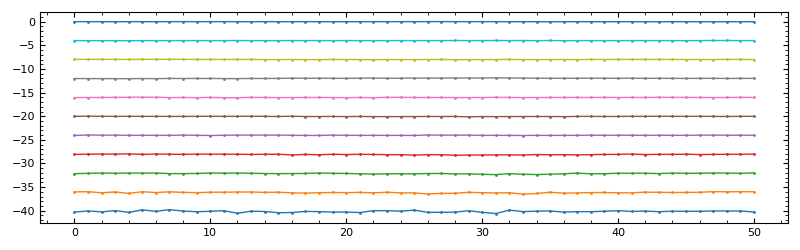

In [913]:
fig, ax = plt.subplots()

for k in range(power_list.shape[0]):
    ax.plot(s21gain[k])

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


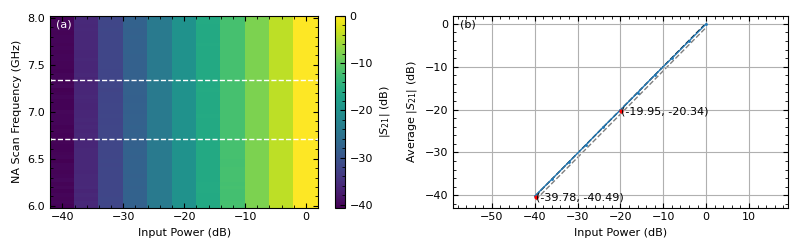

In [914]:
fig, ax = plt.subplots(1, 2)

cax = ax[0].pcolor(power_list, freqs/1e9, s21gain.T)
fig.colorbar(cax, ax=ax[0], label='$|S_{21}|$ (dB)')
for v in JPA_var_config['report']['range']:
    ax[0].axhline(y=v/1e9, c='w', ls='--')

ax[0].set_ylabel(JPA_var_config['lost_setting']['label'])

output_list = s21gain[:, (JPA_var_config['report']['range'][0]<=freqs)*(freqs<=JPA_var_config['report']['range'][1])].mean(axis=1)
ax[1].plot(power_list, output_list)
ax[1].set_ylabel('Average $|S_{21}|$ (dB)')
ax[1].axis('equal')
ax[1].grid(True)

for i in range(2):
    ax[i].set_xlabel('Input Power (dB)')
    ax[i].text(0.02, 0.98, f"({chr(ord('a')+i)})", ha='left', va='top', transform=ax[i].transAxes,
               c='k' if i else 'w')
    
sec = DataPicker(ax[1])

fig.tight_layout()
fig.show()
plt.suptitle(JPA_var_config['jpa_name'], y=0.05)   

In [915]:
drx, dry = sec.get_xy()

popt = np.polyfit(power_list[(drx[0]<=power_list)*(power_list<=drx[-1])],
                  output_list[(drx[0]<=power_list)*(power_list<=drx[-1])], deg=1)

new_power_list = np.linspace(drx[0], drx[1]*2-drx[0], 101)
ax[1].plot(new_power_list, np.poly1d(popt)(new_power_list), 'k--', zorder=-1)
ax[1].plot(new_power_list, np.poly1d(popt)(new_power_list)-1, 'k--', zorder=-1, alpha=0.5)
ax[1].axis('equal')

fig.tight_layout()

In [916]:
drxx, dryy = sec.get_xy()
JPA_var_config['report']['dymanic_range'] = dryy[-1]

In [917]:
fig.savefig(JPA_var_config['jpa_name']+'_Dynamic_range')
JPA_var_config['report']['FIG4'] = JPA_var_config['jpa_name']+'_Dynamic_range.pdf'
JPA_var_config['report']

{'Idle_point_without_pump': np.float64(0.018745877986025783),
 'FIG2': 'JPA20240105_3R_13_Scan_SNR_vs_Bias.pdf',
 'gain': np.float64(16.04184352460547),
 'bandwith': 628133540.5390917,
 'range': array([6.71110337e+09, 7.33923691e+09]),
 'FIG3': 'JPA20240105_3R_13_Opt_Gain.pdf',
 'dymanic_range': np.float64(-20.340639890624118),
 'FIG4': 'JPA20240105_3R_13_Dynamic_range.pdf'}

# Report Tex

In [923]:
JPA_var_config['report']

{'Idle_point_without_pump': np.float64(0.018745877986025783),
 'FIG2': 'JPA20240105_3R_13_Scan_SNR_vs_Bias.pdf',
 'gain': np.float64(0.013728733502361696),
 'bandwith': 604994054.6967897,
 'range': array([6.71058264e+09, 7.31557669e+09]),
 'FIG3': 'JPA20240105_3R_13_Opt_Gain.pdf',
 'dymanic_range': np.float64(-20.340639890624118),
 'FIG4': 'JPA20240105_3R_13_Dynamic_range.pdf'}

In [924]:
def get_report(tester_name='李四'):
    ret = (r'''\documentclass[a4paper]{article}
\usepackage{graphicx}
\usepackage{fancyhdr}
\usepackage{tikz}
\usepackage{eso-pic}
\usepackage{xeCJK}
\usepackage{tabularx}
\usepackage{booktabs}

\newcommand{\modelofthejpa}{XG\_WJPA\_gen1}
'''+f'''\\newcommand{{\\nameofthetester}}{{{tester_name}}}
\\newcommand{{\\idofthejpa}}{{'''+(r'\_').join(JPA_var_config['jpa_name'].split('_'))+f'''}}
\\newcommand{{\\defaultpowerofthesignal}}{{{JPA_var_config['lost_setting']['params']['Power']:.0f}}}
\\newcommand{{\\repeattimes}}{{{JPA_var_config['lost_setting']['repeat']}}}
\\newcommand{{\\defaultoffpowerofmw}}{{${JPA_var_config['opt_params']['mw_power']['off_value']:.0f}\\,\\mathrm{{dBm}}$}}
\\newcommand{{\\gainofthejpa}}{{${JPA_var_config['report']['gain']:.1f}\\,\\mathrm{{dB}}$}}
\\newcommand{{\\bandwidthofthejpa}}{{${JPA_var_config['report']['bandwith']/1e6:.0f}\\,\\mathrm{{MHz}}$}}
\\newcommand{{\\workingfrequencyofthejpa}}{{${JPA_var_config['report']['range'][0]/1e9:.3f}\\,\\mathrm{{GHz}}-{JPA_var_config['report']['range'][1]/1e9:.3f}\\,\\mathrm{{GHz}}$}}
\\newcommand{{\\dynamicrangeofthejpa}}{{${JPA_var_config['report']['dymanic_range']:.0f}\\,\\mathrm{{dB}}$}}
\\newcommand{{\\mwfrequencyofthebestpoint}}{{${JPA_var_config['opt_params']['mw_frequency']['final']/1e9:.3f}$}}
\\newcommand{{\\mwpowerofthebestpoint}}{{${JPA_var_config['opt_params']['mw_power']['final']:.2f}$}}
\\newcommand{{\\dcbiasofthebestpoint}}{{${JPA_var_config['opt_params']['dc_bias']['final']*1000:.0f}$}}
\\newcommand{{\\dcbiasoftheidlepoint}}{{${JPA_var_config['report']['Idle_point_without_pump']*1e3:.0f}$}}

'''+r'''% 页面尺寸设置
\usepackage[top=1in, bottom=1in, left=0.6in, right=0.6in]{geometry}
\renewcommand{\today}{\number\year 年 \number\month 月 \number\day 日}

% 页眉设置
\pagestyle{fancy}
\fancyhf{} % 清除所有页眉页脚
\renewcommand{\headrulewidth}{0.4pt} % 页眉横线粗细
\renewcommand{\footrulewidth}{0.4pt} % 页脚横线粗细

% 自定义页眉内容
\fancyhead[L]{\includegraphics[height=0.8cm]{XGM-LOGO.jpg} 相干(北京)科技有限公司} % 左侧页眉
% \fancyhead[C]{}    % 居中页眉
\fancyhead[R]{北京市海淀区西三旗建材城内3幢3层310号}      % 右侧页眉

% 自定义页脚内容
\fancyfoot[L]{测试人：\nameofthetester} % 左侧页脚
\fancyfoot[C]{第\thepage\ 页}       % 居中页脚
\fancyfoot[R]{测试日期：\today}             % 右侧页脚

% 行间距调整
\usepackage{setspace}
\setstretch{1.4}

% 水印设置
\AddToShipoutPictureFG{%
  \begin{tikzpicture}[remember picture, overlay]
    \node[opacity=0.4] at (current page.center)
      {\includegraphics[width=\paperwidth]{watermark.png}}; % 水印图片路径
  \end{tikzpicture}
}

% 章节标题设置
\usepackage{titlesec}
\titleformat{\section}{\centering\normalfont\huge\bfseries}{}{0em}{}

% 图表caption修改
\usepackage[]{caption2}
\renewcommand{\figurename}{图}
\renewcommand{\tablename}{表}

\begin{document}

\section{宽带约瑟夫森参量放大器测试报告}

\subsection*{概述}

\begin{minipage}[!t]{0.69\textwidth}
\hspace{2em}宽带约瑟夫森参量放大器（Wide-band Josephson parametric amplifier，WJPA，型号：\modelofthejpa ）是一款近量子噪声极限的高性能前置放大器，能显著提升极微弱信号测量的信噪比和测量效率，适合于多量子比特芯片的高效读取、暗物质探测等极端精密测量。

\hspace{2em}本报告给出编号\idofthejpa 的WJPA在极低温下的放大性能评估。测试指标如下：
\end{minipage}
\hfill
\begin{minipage}[!t]{0.27\textwidth}
    \includegraphics[width=\linewidth]{JPA-picture.jpeg}
\end{minipage}

\begin{table*}[!h]
    \centering
    \renewcommand{\arraystretch}{1.4}
    \begin{tabular}{ccc}
        \toprule
        测试指标 & 本WJPA性能表现 & 指标说明\\
        \midrule
        增益$G$（Gain） & \gainofthejpa & 带内平均增益水平(pump on/pump off) \\
        带宽（Bandwidth） & \bandwidthofthejpa & $G \geq 10\,\mathrm{dB}$带宽 \\
        工作频率范围（Working frequency range）& \workingfrequencyofthejpa & 信噪比增益$\geq 5\,\mathrm{dB}$的频率范围\\
        动态范围（Dynamic range）& \dynamicrangeofthejpa & 增益压缩$1\,\mathrm{dB}$的输出信号功率\\
        \bottomrule
    \end{tabular}
\end{table*}

\subsection*{测试环境}

\hspace{2em}测试在一台稀释制冷机内进行。器件安装与测试线路如图\ref{fig:1}所示，未做特殊说明时VNA的测量输出功率是\defaultpowerofthesignal 。

\begin{figure*}[!h]
    \centering
    \includegraphics[width=\linewidth]{JPA_test_circuit.pdf}
    \caption{器件安装与测试线路示意}
    \label{fig:1}
\end{figure*}

\subsection*{测试结果}

\hspace{2em}对WJPA性能的评估可以通过输出信号的$S_{21}$或者信噪比（Signal to noise ratio，SNR）的对比来实现。其中$S_{21}$通过VNA直接采集得到，SNR通过VNA多次采集$S_{21}$后通过“平均值/标准差”实现。本报告中SNR采集是重复\repeattimes 次的结果。

\begin{table*}[!ht]
    \centering
    \renewcommand{\arraystretch}{1.4}
    \begin{tabular}{ccccc}
        \toprule
        MW Frequency （GHz) &  MW Power (dBm) & DC Bias (mV) & 条件\\
        \midrule
        $-$ & $-$ & \dcbiasoftheidlepoint & 非工作状态最佳偏置点 \\
        \mwfrequencyofthebestpoint & \mwpowerofthebestpoint & \dcbiasofthebestpoint & 推荐工作点\\
        \bottomrule
    \end{tabular}
\end{table*}

\subsubsection*{非工作状态偏置测试}
\hspace{2em}测试WJPA在非工作状态（关泵浦微波）下不同直流偏置时的响应特性，如图\ref{fig:2}所示。
\begin{figure*}[h]
    \centering
    \includegraphics[width=\linewidth]{'''+f'''{JPA_var_config['report']['FIG2']}'''+r'''}
    \caption{非工作状态偏置的响应}
    \label{fig:2}
\end{figure*}

\subsubsection*{增益测试}

\hspace{2em}测试推荐工作点下的增益随输入信号频率的变化。图\ref{fig:2}分别给出泵浦开关前后S21曲线对比（图\ref{fig:2} (a)）、增益曲线（图\ref{fig:2} (b)）、泵浦开关前后信噪比对比（图\ref{fig:2} (c)）和信噪比增益曲线（图\ref{fig:2} (d)）。

\begin{figure*}[h]
    \centering
    \includegraphics[width=\linewidth]{'''+f'''{JPA_var_config['report']['FIG3']}'''+r'''}
    \caption{增益响应}
    \label{fig:3}
\end{figure*}

\subsubsection*{动态范围测试}
\hspace{2em}测试增益压缩$1\,\mathrm{dB}$时对应的输出信号功率。图\ref{fig:4}给出不同频率下的1dB压缩功率曲线。

\begin{figure*}[h]
    \centering
    \includegraphics[width=\linewidth]{'''+f'''{JPA_var_config['report']['FIG4']}'''+r'''}
    \caption{WJPA工作时不同输入功率的输出响应和工作频率范围内的平均响应}
    \label{fig:4}
\end{figure*}

\subsubsection*{器件尺寸}

\begin{figure*}[!h]
    \centering
    \includegraphics[width=\linewidth]{design.png}
    \caption{器件尺寸标注（单位：mm）}
    \label{fig:5}
\end{figure*}

注：由于约瑟夫森结的特性在不同升降温循环中会发生轻微变化，本测试报告中给出的推荐工作点仅作为参考。实际使用时需重新搜寻工作点。

\end{document}''')
    return ret

In [925]:
with open(JPA_var_config['jpa_name']+'.tex', 'w') as f:
    f.write(get_report(tester_name='李金凤'))

# Optimize Class

In [14]:
from dataclasses import dataclass
from queue import Queue
from typing import Any, Sequence, Union

import nevergrad as ng
from scipy.optimize import OptimizeResult

@dataclass
class VarData:
    pattern: str = 'mul'
    init: float = 1
    low: float = 0.9
    high: float = 1.1

    def get(self, key, default=None):
        return self.__getattribute__(key)


def init_variable(variable: list[dict]) -> ng.p.Array:
    init, low, high = [], [], []
    for item in variable:
        init.append(item.get('init', 1))
        if item.get('pattern', 'mul') in ['add']:
            low.append(init[-1] + item.get('low', 0.9))
            high.append(init[-1] + item.get('high', 1.1))
        else:
            low.append(init[-1] * item.get('low', 0.9))
            high.append(init[-1] * item.get('high', 1.1))
    return ng.p.Array(init=init, lower=low, upper=high)


class NgOpt():

    def __init__(self,
                 variable: Union[list[dict], list[VarData], ng.p.Array],
                 config: dict = {},
                 **kw):

        self._catch, self._all_x, self._all_y = Queue(), [], []
        self.config = {
            'method': 'TBPSA',
            'budget': 300,
        }

        self.config.update(config)
        if not isinstance(variable, ng.p.Array):
            variable = init_variable(variable=variable)
        self.opt = getattr(ng.optimizers,
                           self.config['method'])(variable,
                                                  budget=self.config['budget'])

    def ask(self):
        tmp = self.opt.ask()
        self._catch.put(tmp)
        return tmp.args[0]

    def tell(self, suggested: Sequence, value: Any):
        if not self._catch.empty():
            tmp = self._catch.get()
            self._all_x.append(tmp.args[0])
            self._all_y.append(value)
            self.opt.tell(tmp, value)

    def get_result(self, history: bool = False) -> OptimizeResult:
        ret = OptimizeResult({'x': self.opt.recommend().args[0]})
        if history:
            ret.x_iters = self._all_x
            ret.func_vals = self._all_y
        return ret